In [68]:
import mxnet as mx
from skimage import io
from model import get_network
from train2 import load_model
import time
import numpy as np
import seaborn as sns
%matplotlib inline
import cv2

In [60]:
def predict(left_dir,right_dir):  
    left = io.imread(left_dir).swapaxes(2,1).swapaxes(1,0) - 128.0
    right= io.imread(right_dir).swapaxes(2,1).swapaxes(1,0) - 128.0
    s = (1,3,left.shape[1],left.shape[2])
    ctx = mx.gpu(3)
    net,executor =  load_model('stereo',450,s,'fully',ctx)
    args  = dict(zip(net.list_arguments(),executor.arg_arrays))
    args['left'][:] = np.array([left])
    args['right'][:] = np.array([right])
    executor.forward(is_train=False)
    return left,right,executor.outputs[0].asnumpy()[0],executor.outputs[1].asnumpy()[0]

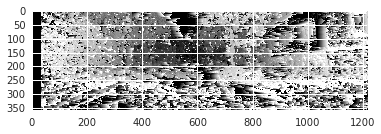

In [67]:
left,right,left_pred,right_pred = predict('./colored_0/000000_10.png','./colored_1/000000_10.png')
dis_pred = np.zeros((left_pred.shape[1],left_pred.shape[2]))
dis_range = 32
for y  in range(left_pred.shape[1]):
    for x in range(dis_range,left_pred.shape[2]):
        dis_pred[y,x] = np.dot(left_pred[:,y,x],right_pred[:,y,x-dis_range:x+1])[::-1].argmax()
io.imshow(dis_pred)

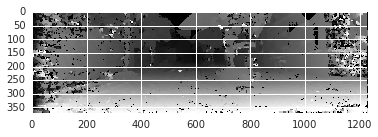

In [88]:
window_size = 20
left = io.imread('./colored_0/000000_10.png')
right = io.imread('./colored_1/000000_10.png')
stereo = cv2.StereoSGBM(minDisparity = 0,
        numDisparities = 64,
        SADWindowSize = 8,
        P1 = 1,
        P2 = 32,
        disp12MaxDiff = 50,
        uniquenessRatio = 1,
        speckleWindowSize = 30,
        speckleRange = 6)
disparity = stereo.compute(left,right)
io.imshow(disparity)

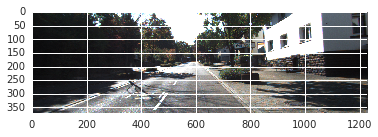

In [76]:
io.imshow(left)

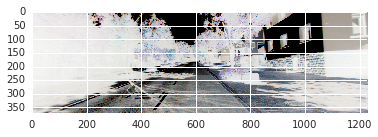

In [64]:
io.imshow(left.swapaxes(0,1).swapaxes(1,2)+128.0)

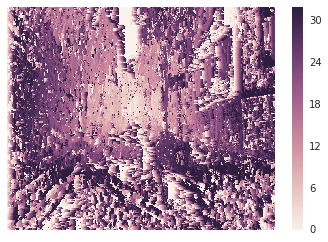

In [115]:
sns.heatmap(dis_pred,xticklabels=False,yticklabels=False)

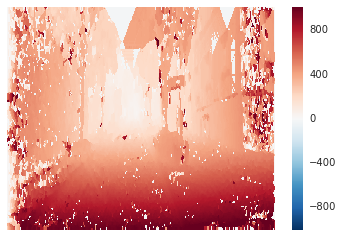

In [116]:
sns.heatmap(disparity,xticklabels=False,yticklabels=False)

In [117]:
disparity.max()

1008

1.77489519119
3.72670102119


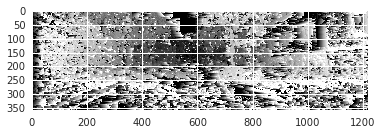

In [114]:
begin = time.time()
ctx = mx.gpu(3)
left,right,left_pred,right_pred = predict('./colored_0/000000_10.png','./colored_1/000000_10.png')
print time.time() - begin
dis_pred = np.zeros((left_pred.shape[1],left_pred.shape[2]))
dis_range = 32
for y  in range(left_pred.shape[1]):
    left_embedding = mx.nd.array(left_pred[:,y].T,ctx)
    right_embedding = mx.nd.array(right_pred[:,y],ctx)
    tmp = mx.nd.dot(left_embedding,right_embedding).asnumpy()
    for x in range(left_pred.shape[2]):
        if x - dis_range <0:
            t = 0
        else:
            t = x - dis_range
        dis_pred[y,x] = tmp[x,t:x+1][::-1].argmax()
io.imshow(dis_pred)
print time.time() - begin

In [108]:
tmp[2,2:4]

array([ 0.55448067,  0.62883455], dtype=float32)